In [1]:
import pickle
from os.path import join
from random import sample
import numpy as np
import pandas as pd
import shap
from s2apler.data import PDData
from s2apler.featurizer import FeaturizationInfo, many_pairs_featurize
from s2apler.model import PairwiseModeler, Clusterer
from s2apler.eval import pairwise_eval, cluster_eval
from s2apler.consts import DEFAULT_CHUNK_SIZE, PROJECT_ROOT_PATH, CONFIG
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.metrics import average_precision_score

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk')

/net/nfs2.s2-research/sergeyf/miniconda3/envs/s2apler/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-11-21 18:52:59,956 - s2apler - WARNING - You haven't set `main_data_dir` in data/path_config.json! Using data/ as default data directory.


In [4]:
from s2apler.eval import *


def pairwise_eval(
    X: np.array,
    y: np.array,
    classifier: Any,
    figs_path: str,
    title: str,
    shap_feature_names: List[str],
    thresh_for_f1: float = 0.5,
    shap_plot_type: Optional[str] = "dot",
    nameless_classifier: Optional[Any] = None,
    nameless_X: Optional[np.array] = None,
    nameless_feature_names: Optional[List[str]] = None,
    skip_shap: bool = False,
) -> Dict[str, float]:
    """
    Performs pairwise model evaluation, without using blocks.
    Also writes plots to the provided file path

    Parameters
    ----------
    X: np.array
        Feature matrix of features to do eval on.
    y: np.array
        Feature matrix of labels to do eval on.
    classifier: sklearn compatible classifier
        Classifier to do eval on.
    figs_path: string
        Where to put the resulting evaluation figures.
    title: string
        Title to stick on all the plots and use for file name.
    shap_feature_names: List[str]
        List of feature names for the SHAP plots.
    thresh_for_f1: float
        Threshold for F1 computation. Defaults to 0.5.
    shap_plot_type: str
        Type of shap plot. Defaults to 'dot'.
        Can also be: 'bar', 'violin', 'compact_dot'
    nameless_classifier: sklearn compatible classifier
        Classifier to do eval on that doesn't use name features.
    nameless_X: np.array
        Feature matrix of features to do eval on excluding name features.
    nameless_feature_names: List[str]
        List of feature names for the SHAP plots excluding name features.
    skip_shap: bool
        Whether to skip SHAP entirely.

    Returns
    -------
    Dict: A dictionary of common pairwise metrics.
    """
    if not os.path.exists(figs_path):
        os.makedirs(figs_path)

    # filename base will be title but lower and underscores
    base_name = title.lower().replace(" ", "_")
    if hasattr(classifier, "classifier"):
        classifier = classifier.classifier

    if nameless_classifier is not None and hasattr(nameless_classifier, "classifier"):
        nameless_classifier = nameless_classifier.classifier

    if nameless_classifier is not None:
        y_prob = (classifier.predict_proba(X)[:, 1] + nameless_classifier.predict_proba(nameless_X)[:, 1]) / 2
    else:
        y_prob = classifier.predict_proba(X)[:, 1]

    # plot AUROC
    fpr, tpr, _ = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(0, figsize=(15, 15))
    plt.plot(fpr, tpr, lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {title}")
    plt.legend(loc="lower right")
    plt.savefig(join(figs_path, base_name + "_roc.png"))
    plt.clf()
    plt.close()

    # plot AUPR
    precision, recall, _ = precision_recall_curve(y, y_prob)
    avg_precision = average_precision_score(y, y_prob)

    plt.figure(1, figsize=(15, 15))
    plt.plot(
        precision,
        recall,
        lw=2,
        label="PR curve (average precision = %0.2f)" % avg_precision,
    )
    plt.xlabel("Precision")
    plt.ylabel("Recall")
    plt.title(f"PR Curve for {title}")
    plt.legend(loc="lower left")
    plt.savefig(join(figs_path, base_name + "_pr.png"))
    plt.clf()
    plt.close()

    # plot SHAP
    # note that SHAP doesn't support model stacking directly
    # so we have to approximate by getting SHAP values for each
    # of the models inside the stack
    if not skip_shap:
        from s2apler.model import VotingClassifier  # avoid circular import

        if isinstance(classifier, VotingClassifier):
            shap_values_all = []
            for c in classifier.estimators:
                if isinstance(c, CalibratedClassifierCV):
                    shap_values_all.append(shap.TreeExplainer(c.base_estimator).shap_values(X)[1])
                else:
                    shap_values_all.append(shap.TreeExplainer(c).shap_values(X)[1])
            shap_values = [np.mean(shap_values_all, axis=0)]
        elif nameless_classifier is not None:
            shap_values = []
            for c, d in [(classifier, X), (nameless_classifier, nameless_X)]:
                if isinstance(classifier, CalibratedClassifierCV):
                    shap_values.append(shap.TreeExplainer(c.base_estimator).shap_values(d)[1])
                else:
                    shap_values.append(shap.TreeExplainer(c).shap_values(d)[1])
        elif isinstance(classifier, CalibratedClassifierCV):
            shap_values = shap.TreeExplainer(classifier.base_estimator).shap_values(X)[1]
        else:
            shap_values = shap.TreeExplainer(classifier).shap_values(X)[1]

        if isinstance(shap_values, list):
            for i, (shap_value, feature_names, d) in enumerate(
                zip(
                    shap_values,
                    [shap_feature_names, nameless_feature_names],
                    [X, nameless_X],
                )
            ):
                assert feature_names is not None, "neither feature_names should be None here"
                plt.figure(2 + i)
                shap.summary_plot(
                    shap_value,
                    d,
                    plot_type=shap_plot_type,
                    feature_names=feature_names,
                    show=False,
                    max_display=len(feature_names),
                )
                # plt.title(f"{i}: SHAP Values for {title}")
                plt.tight_layout()
                plt.savefig(join(figs_path, base_name + f"_shap_{i}.png"))
                plt.clf()
                plt.close()
        else:
            plt.figure(2)
            shap.summary_plot(
                shap_values,
                X,
                plot_type=shap_plot_type,
                feature_names=shap_feature_names,
                show=False,
                max_display=len(shap_feature_names),
            )
            # plt.title(f"SHAP Values for {title}")
            plt.tight_layout()
            plt.savefig(join(figs_path, base_name + "_shap.png"))
            plt.clf()
            plt.close()

    # collect metrics and return
    pr, rc, f1, _ = precision_recall_fscore_support(y, y_prob > thresh_for_f1, beta=1.0, average="macro")
    metrics = {
        "AUROC": np.round(roc_auc, 3),
        "Average Precision": np.round(avg_precision, 3),
        "F1": np.round(f1, 3),
        "Precision": np.round(pr, 3),
        "Recall": np.round(rc, 3),
    }

    return metrics, shap_values

In [5]:
features_to_use = [
    "author_similarity",
    "venue_similarity",
    "year_diff",
    "title_similarity",
    "abstract_similarity",
    "paper_quality",
]

nameless_features_to_use = [
    feature_name
    for feature_name in features_to_use
    if feature_name not in {"title_similarity", "abstract_similarity"}
]

featurization_info = FeaturizationInfo(features_to_use=features_to_use)
nameless_featurization_info = FeaturizationInfo(
    features_to_use=nameless_features_to_use
)

feature_names = featurization_info.get_feature_names()
nameless_feature_names = nameless_featurization_info.get_feature_names()

In [6]:
dataset = PDData(
    join(CONFIG["main_data_dir"], "papers.json"),
    clusters=join(CONFIG["main_data_dir"], "clusters.json"),
    name="test_dataset",
    n_jobs=16,
    balanced_pair_sample=False,
    train_pairs_size=5000000,
    val_pairs_size=5000000,
    test_pairs_size=5000000
)

(
    train_papers_dict,
    val_papers_dict,
    test_papers_dict,
) = dataset.split_cluster_papers()  # type: ignore

train_pairs, val_pairs, test_pairs = dataset.split_pairs(
    train_papers_dict, val_papers_dict, test_papers_dict
)

inverse_papers_dict = {}
for k, v in train_papers_dict.items():
    for v_i in v:
        inverse_papers_dict[v_i] = k
        
for k, v in val_papers_dict.items():
    for v_i in v:
        inverse_papers_dict[v_i] = k
        
for k, v in test_papers_dict.items():
    for v_i in v:
        inverse_papers_dict[v_i] = k

2022-11-21 18:57:34,003 - s2apler - INFO - loading papers
2022-11-21 18:58:55,958 - s2apler - INFO - loaded papers
2022-11-21 18:58:55,961 - s2apler - INFO - loading clusters
2022-11-21 18:59:21,144 - s2apler - INFO - loaded clusters, loading specter
2022-11-21 18:59:21,145 - s2apler - INFO - loaded specter, loading cluster seeds
2022-11-21 18:59:21,146 - s2apler - INFO - loaded cluster seeds
2022-11-21 18:59:21,147 - s2apler - INFO - making paper to cluster id
2022-11-21 18:59:22,033 - s2apler - INFO - made paper to cluster id
2022-11-21 18:59:23,828 - s2apler - INFO - preprocessing papers
Preprocessing papers: 100%|██████████| 1783603/1783603 [07:24<00:00, 4013.16it/s] 
2022-11-21 19:06:56,121 - s2apler - INFO - preprocessed papers


In [7]:
train_features = many_pairs_featurize(
    train_pairs,
    dataset,
    featurization_info,
    16,
    False,
    DEFAULT_CHUNK_SIZE,
    nameless_featurization_info,
    np.nan,
    False,
)

val_features = many_pairs_featurize(
    val_pairs,
    dataset,
    featurization_info,
    16,
    False,
    DEFAULT_CHUNK_SIZE,
    nameless_featurization_info,
    np.nan,
    False,
)

test_features = many_pairs_featurize(
    test_pairs,
    dataset,
    featurization_info,
    16,
    False,
    DEFAULT_CHUNK_SIZE,
    nameless_featurization_info,
    np.nan,
    False,
)

with open(join(PROJECT_ROOT_PATH, "data", "training_data_v2022_11_21.pickle"), 'wb') as f:
    pickle.dump((train_papers_dict, train_pairs, train_features, val_papers_dict, val_pairs, val_features, test_papers_dict, test_pairs, test_features), f)

2022-11-21 19:10:28,632 - s2apler - INFO - Creating 1075145 pieces of work
Creating work: 1075145it [00:01, 571080.04it/s]
2022-11-21 19:10:30,520 - s2apler - INFO - Created pieces of work
2022-11-21 19:10:30,521 - s2apler - INFO - Cached changed, doing 1075145 work in parallel
Doing work: 100%|██████████| 1075145/1075145 [00:30<00:00, 35261.82it/s]
2022-11-21 19:11:22,335 - s2apler - INFO - Work completed
2022-11-21 19:11:22,337 - s2apler - INFO - Making numpy arrays for features and labels
2022-11-21 19:11:22,764 - s2apler - INFO - Numpy arrays made
2022-11-21 19:11:23,219 - s2apler - INFO - Creating 140686 pieces of work
Creating work: 140686it [00:00, 482168.99it/s]
2022-11-21 19:11:23,514 - s2apler - INFO - Created pieces of work
2022-11-21 19:11:23,514 - s2apler - INFO - Cached changed, doing 140686 work in parallel
Doing work: 100%|██████████| 140686/140686 [00:04<00:00, 34836.66it/s]
2022-11-21 19:11:50,844 - s2apler - INFO - Work completed
2022-11-21 19:11:50,845 - s2apler - I

Text(0, 0.5, 'number of clusters')

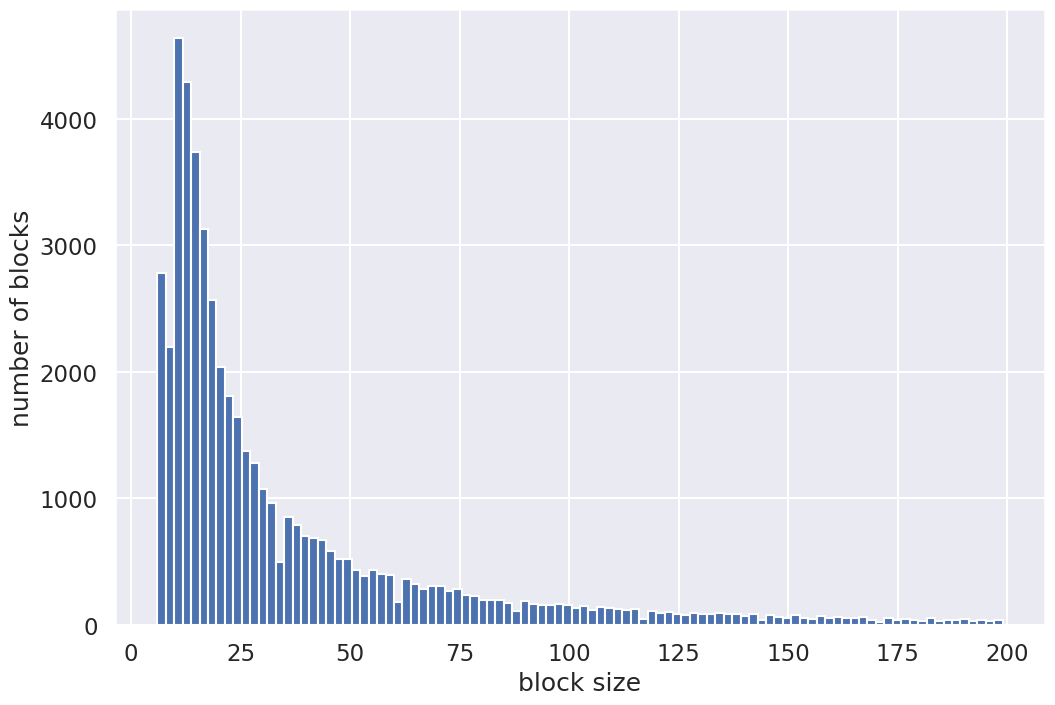

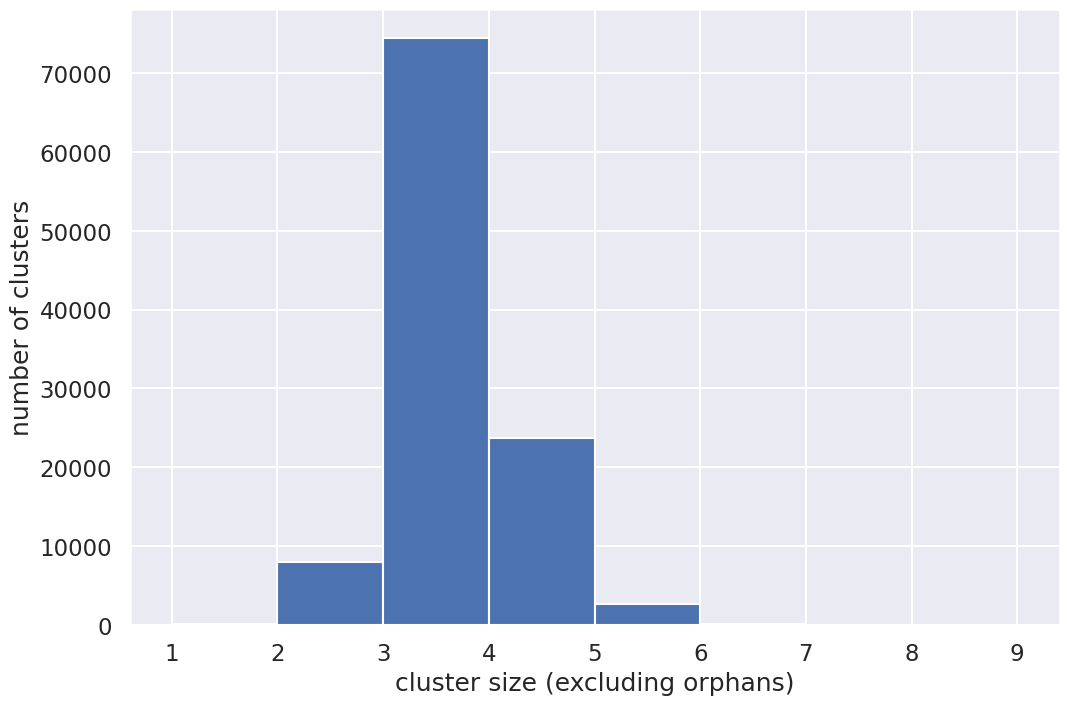

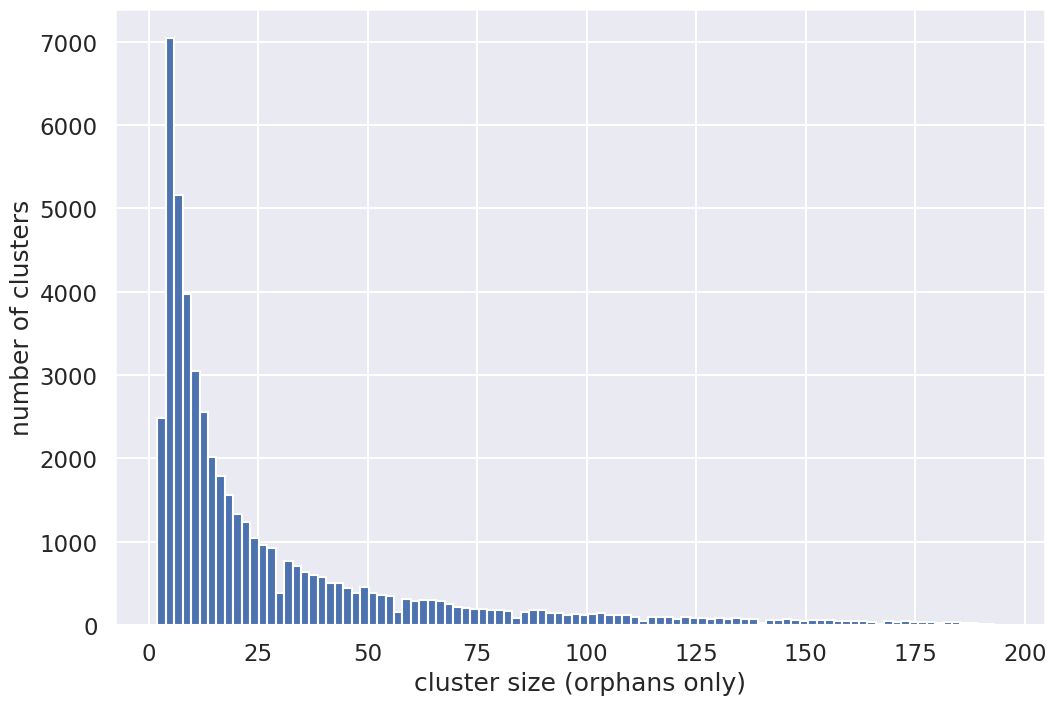

In [9]:
# plot block sizes
blocks = dataset.get_blocks()
block_sizes = np.array([len(i) for i in blocks.values()])
cluster_sizes_no_orphans = np.array([len(i['sourced_paper_ids']) for k, i in dataset.clusters.items() if not k.endswith('_orphans')])
cluster_sizes_orphans = np.array([len(i['sourced_paper_ids']) for k, i in dataset.clusters.items() if k.endswith('_orphans')])

plt.figure(figsize=(12, 8))
plt.hist(block_sizes, bins=100)
plt.xlabel('block size')
plt.ylabel('number of blocks')

plt.figure(figsize=(12, 8))
plt.hist(cluster_sizes_no_orphans, bins=range(1, 10))
plt.xlabel('cluster size (excluding orphans)')
plt.ylabel('number of clusters')

plt.figure(figsize=(12, 8))
plt.hist(cluster_sizes_orphans, bins=100)
plt.xlabel('cluster size (orphans only)')
plt.ylabel('number of clusters')

In [ ]:
with open(join(PROJECT_ROOT_PATH, "data", "training_data_v2022_11_21.pickle"), 'rb') as f:
    train_papers_dict, train_pairs, train_features, val_papers_dict, val_pairs, val_features, test_papers_dict, test_pairs, test_features = pickle.load(f)

In [7]:
X_train, y_train, nameless_X_train = train_features
X_val, y_val, nameless_X_val = val_features
X_test, y_test, nameless_X_test = test_features

all_metrics = []
for i in range(X_train.shape[1]):
    sub_inds = list(range(X_train.shape[1]))
    sub_inds.remove(i)
    model = PairwiseModeler(n_iter=3, n_jobs=15)
    model.fit(X_train[:, sub_inds], y_train, X_val[:, sub_inds], y_val)
    y_pred = model.predict_proba(X_test[:, sub_inds])
    classifier = model.classifier
    y_prob = classifier.predict_proba(X_test[:, sub_inds])[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    avg_precision = average_precision_score(y_test, y_prob)
    pr, rc, f1, _ = precision_recall_fscore_support(y_test, y_prob > 0.65, beta=1.0, average="macro")
    metrics = {
        "Feature Removed": feature_names[i],
        "AUROC": np.round(roc_auc, 4),
        "Average Precision": np.round(avg_precision, 4),
        "F1 (0.65 thresh)": np.round(f1, 4),
        "Precision": np.round(pr, 4),
        "Recall": np.round(rc, 4),
        "Accuracy (0.65 thresh)": np.round(np.mean(y_test == (y_prob > 0.65)), 4),
    }
    print(metrics)
    all_metrics.append(metrics)
    
# remove nothing
sub_inds = list(range(X_train.shape[1]))
model = PairwiseModeler(n_iter=3, n_jobs=15)
model.fit(X_train[:, sub_inds], y_train, X_val[:, sub_inds], y_val)
y_pred = model.predict_proba(X_test[:, sub_inds])
classifier = model.classifier
y_prob = classifier.predict_proba(X_test[:, sub_inds])[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
avg_precision = average_precision_score(y_test, y_prob)
pr, rc, f1, _ = precision_recall_fscore_support(y_test, y_prob > 0.65, beta=1.0, average="macro")
metrics = {
    "Feature Removed": "None",
    "AUROC": np.round(roc_auc, 4),
    "Average Precision": np.round(avg_precision, 4),
    "F1 (0.65 thresh)": np.round(f1, 4),
    "Precision": np.round(pr, 4),
    "Recall": np.round(rc, 4),
    "Accuracy (0.65 thresh)": np.round(np.mean(y_test == (y_prob > 0.65)), 4),
}
print(metrics)
all_metrics.append(metrics)
df_results = pd.DataFrame(all_metrics)
df_results

100%|██████████| 3/3 [00:43<00:00, 14.66s/trial, best loss: -0.9860376866240141]
{'Feature Removed': 'author_names_similarity', 'AUROC': 0.9992, 'Average Precision': 0.9981, 'F1 (0.65 thresh)': 0.984, 'Precision': 0.9859, 'Recall': 0.9821, 'Accuracy (0.65 thresh)': 0.9864}
100%|██████████| 3/3 [00:47<00:00, 15.91s/trial, best loss: -0.98679813886249]
{'Feature Removed': 'author_first_letter_compatibility', 'AUROC': 0.9993, 'Average Precision': 0.9983, 'F1 (0.65 thresh)': 0.9852, 'Precision': 0.9866, 'Recall': 0.9839, 'Accuracy (0.65 thresh)': 0.9875}
100%|██████████| 3/3 [00:47<00:00, 15.79s/trial, best loss: -0.987397287532993] 
{'Feature Removed': 'venue_similarity', 'AUROC': 0.9994, 'Average Precision': 0.9986, 'F1 (0.65 thresh)': 0.9859, 'Precision': 0.9876, 'Recall': 0.9842, 'Accuracy (0.65 thresh)': 0.988}
100%|██████████| 3/3 [00:45<00:00, 15.12s/trial, best loss: -0.9859664483495463]
{'Feature Removed': 'year_diff', 'AUROC': 0.9992, 'Average Precision': 0.9982, 'F1 (0.65 thresh

,Feature Removed,AUROC,Average Precision,F1 (0.65 thresh),Precision,Recall,Accuracy (0.65 thresh)
0,author_names_similarity,0.9992,0.9981,0.9840,0.9859,0.9821,0.9864
1,author_first_letter_compatibility,0.9993,0.9983,0.9852,0.9866,0.9839,0.9875
2,venue_similarity,0.9994,0.9986,0.9859,0.9876,0.9842,0.9880
3,year_diff,0.9992,0.9982,0.9840,0.9860,0.9822,0.9865
4,title_character_similarity,0.9993,0.9983,0.9855,0.9868,0.9842,0.9877
5,title_numeral_similarity,0.9994,0.9986,0.9862,0.9876,0.9848,0.9883
6,title_special_publication_word_similarity,0.9994,0.9986,0.9859,0.9875,0.9843,0.9880
7,title_year_similarity,0.9994,0.9986,0.9861,0.9877,0.9846,0.9883
8,title_levenshtein,0.9994,0.9986,0.9860,0.9876,0.9844,0.9881
9,title_prefix,0.9993,0.9985,0.9853,0.9873,0.9833,0.9875


In [11]:
"""
Best so far

v3     : {'AUROC': 1.0, 'Average Precision': 0.999, 'F1': 0.991, 'Precision': 0.99, 'Recall': 0.992}
v3_hard: {'AUROC': 0.999, 'Average Precision': 0.999, 'F1': 0.987, 'Precision': 0.987, 'Recall': 0.988}
"""
# let's do some debugging
# for each wrong row, get the papers and print them out for now

X_train, y_train, nameless_X_train = train_features
X_val, y_val, nameless_X_val = val_features
X_test, y_test, nameless_X_test = test_features

model = PairwiseModeler(n_iter=25, n_jobs=15)
model.fit(X_train, y_train, X_val, y_val)
y_pred = model.predict_proba(X_test)
y_pred_val = model.predict_proba(X_val)


if len(X_test) > 50000:
    # subsample for speed
    np.random.seed(seed=0)
    rand_ind = np.random.choice(len(X_test), 50000, replace=False)
else:
    # use all
    rand_ind = np.arange(len(X_test))
metrics, shap_values = pairwise_eval(
    X_test[rand_ind, :], 
    y_test[rand_ind], 
    model, 
    join(PROJECT_ROOT_PATH, "data"), 
    'debug', 
    feature_names,
    thresh_for_f1=0.5, 
)
print(metrics)

100%|██████████| 25/25 [06:08<00:00, 14.73s/trial, best loss: -0.9875812348370707]


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


{'AUROC': 0.999, 'Average Precision': 0.999, 'F1': 0.987, 'Precision': 0.987, 'Recall': 0.988}


In [13]:
# how do our rules do? do they fix errors? do they cause errors?
from s2apler.text import PUBLISHER_SOURCES
preds = model.predict_proba(X_test)[:, 1] > 0.65
doi_label = []
pmid_label = []
pdf_hash_label = []
source_label = []
{'3568424289','3758874283', '3754072317'}
for pr, (paper_1_id, paper_2_id, label) in zip(preds, test_pairs):
    paper_1 = dataset.papers[paper_1_id]
    paper_2 = dataset.papers[paper_2_id]

    if paper_1.doi is not None and paper_2.doi is not None and paper_1.doi == paper_2.doi:
        doi_label.append((label == 1.0, pr == 1))
    elif paper_1.pmid is not None and paper_2.pmid is not None and paper_1.pmid == paper_2.pmid:
        pmid_label.append((label == 1.0, pr == 1))
    elif paper_1.pdf_hash is not None and paper_2.pdf_hash is not None and paper_1.pdf_hash == paper_2.pdf_hash:
        pdf_hash_label.append((label == 1.0, pr == 1))
    elif (
        paper_1.source_id is not None
        and paper_2.source_id is not None
        and paper_1.source in PUBLISHER_SOURCES
        and paper_1.source == paper_2.source
        and paper_1.source_id != paper_2.source_id
    ):
        source_label.append((label == 0.0, pr == 0))

print(
    pd.value_counts(doi_label),
    pd.value_counts(pmid_label),
    pd.value_counts(pdf_hash_label),
    pd.value_counts(source_label),
    sep='\n----------------\n'
)

(True, True)     16805
(True, False)      123
dtype: int64
----------------
Series([], dtype: int64)
----------------
(True, True)      10457
(True, False)       349
(False, False)        1
dtype: int64
----------------
(True, True)    5200
dtype: int64


In [ ]:
# debugging
df = pd.DataFrame({feat: X_train[:, feature_names.index(feat)] for feat in feature_names})
df['y_train'] = y_train
df.groupby(['title_character_similarity'])['y_train'].value_counts(dropna=False, normalize=False)

In [ ]:
test_pairs_sub = np.array(test_pairs)[rand_ind]

def simple_paper(p):
    authors = ', '.join([a.author_info_full_name for a in p.authors])
    abs = p.abstract[:100] + '...' if p.abstract is not None else None
    return f"ID: {p.sourced_paper_id}\nSource: {p.source}\nCluster ID: {dataset.paper_to_cluster_id[p.sourced_paper_id]}\nTitle: {p.title}\nAuthors: {authors}\nVenue: {p.venue}\nJournal: {p.journal_name}\nYear: {p.year}\nAbstract: {abs}\nDOI: {p.doi}"
    

def debug_print(ind):
    x = X_test[rand_ind, :][ind, :]
    sh = shap_values[ind, :]
    p1 = dataset.papers[test_pairs_sub[ind][0]]
    p2 = dataset.papers[test_pairs_sub[ind][1]]
    print("Correct label:", y_test[rand_ind][ind])
    print("Predicted class probs:", np.round(y_pred[rand_ind][ind, :], 3), '\n')
    df = pd.DataFrame({'feature': feature_names, 'value': x, 'shap': sh})
    print(df)
    print("\nPaper 1\n------\n" + simple_paper(p1), '\n')
    print("Paper 2\n------\n" + simple_paper(p2))

print("total wrong:", np.sum(y_test[rand_ind] != (y_pred[rand_ind][:, 1] > 0.65)))
rows_of_interest = (X_test[rand_ind, feature_names.index('title_character_similarity')] == 0) # & ((X_test[rand_ind, feature_names.index('sources_are_same')] == 2.0))
wrong_inds = np.flatnonzero( (y_test[rand_ind] != (y_pred[rand_ind][:, 1] > 0.65)) )# & rows_of_interest)
print(f"total wrong where in rows of interest:", len(wrong_inds))
a = sample(list(wrong_inds), np.minimum(5, len(wrong_inds)))
for i in a:
    debug_print(i)
    print('\n\n===========================================================================\n\n')

In [14]:
X_train, y_train, nameless_X_train = train_features
X_val, y_val, nameless_X_val = val_features
X_test, y_test, nameless_X_test = test_features

model = PairwiseModeler(n_iter=25, n_jobs=16)
model.fit(X_train, y_train, X_val, y_val)

# using default threshold eps of 0.65
cluster = Clusterer(
    featurization_info,
    model.classifier,
    n_iter=25,
    use_default_constraints_as_supervision=True,
    n_jobs=16,
)
cluster.fit(dataset)  

cluster_metrics_constraint, b3_metrics_per_signature_constraint = cluster_eval(
    dataset,
    cluster,
    split="test",
)
cluster_metrics_constraint

100%|██████████| 25/25 [07:17<00:00, 17.48s/trial, best loss: -0.9876507446492604]


2022-11-15 15:55:42,783 - s2and - INFO - Fitting clusterer


Finished loading model, total used 77 iterations


2022-11-15 15:55:48,126 - s2and - INFO - Making 4984 distance matrices
2022-11-15 15:55:48,127 - s2and - INFO - Initializing pairwise_probas
2022-11-15 15:55:48,154 - s2and - INFO - Pairwise probas initialized, starting making all pairs
2022-11-15 15:55:48,155 - s2and - INFO - Featurizing batch 0/7
2022-11-15 15:55:48,156 - s2and - INFO - Getting constraints
2022-11-15 15:55:51,467 - s2and - INFO - Creating 1000000 pieces of work
Creating work: 1000000it [00:01, 758442.94it/s]
2022-11-15 15:55:52,790 - s2and - INFO - Created pieces of work
2022-11-15 15:55:52,791 - s2and - INFO - Cached changed, doing 974906 work in parallel
Doing work: 100%|██████████| 974906/974906 [00:21<00:00, 44893.45it/s]
2022-11-15 15:57:06,330 - s2and - INFO - Work completed
2022-11-15 15:57:06,332 - s2and - INFO - Making numpy arrays for features and labels
2022-11-15 15:57:06,603 - s2and - INFO - Numpy arrays made
2022-11-15 15:57:06,710 - s2and - INFO - Making predict flags
2022-11-15 15:57:07,057 - s2and - 

100%|██████████| 25/25 [00:56<00:00,  2.26s/trial, best loss: -0.999]


2022-11-15 16:05:41,602 - s2and - INFO - Clusterer fit
2022-11-15 16:05:47,142 - s2and - INFO - Making 4984 distance matrices
2022-11-15 16:05:47,144 - s2and - INFO - Initializing pairwise_probas
2022-11-15 16:05:47,167 - s2and - INFO - Pairwise probas initialized, starting making all pairs
2022-11-15 16:05:47,168 - s2and - INFO - Featurizing batch 0/7
2022-11-15 16:05:47,168 - s2and - INFO - Getting constraints
2022-11-15 16:05:50,159 - s2and - INFO - Creating 1000000 pieces of work
Creating work: 1000000it [00:01, 976817.75it/s]
2022-11-15 16:05:51,185 - s2and - INFO - Created pieces of work
2022-11-15 16:05:51,186 - s2and - INFO - Cached changed, doing 977899 work in parallel
Doing work: 100%|██████████| 977899/977899 [00:22<00:00, 44067.70it/s]
2022-11-15 16:06:58,021 - s2and - INFO - Work completed
2022-11-15 16:06:58,022 - s2and - INFO - Making numpy arrays for features and labels
2022-11-15 16:06:58,242 - s2and - INFO - Numpy arrays made
2022-11-15 16:06:58,341 - s2and - INFO - 

{'B3 (P, R, F1)': (0.999, 0.998, 0.999),
 'Pred bigger ratio (mean, count)': (1.0, 34429),
 'True bigger ratio (mean, count)': (1.87, 125)}

In [15]:
sorted(list(zip([i['misc']['vals']['eps'][0] for i in cluster.hyperopt_trials_store.trials], cluster.hyperopt_trials_store.losses())))

[(0.20472833689773862, -0.988),
 (0.22051974391033452, -0.989),
 (0.28351728469421333, -0.992),
 (0.3309559021969119, -0.994),
 (0.37233382248823377, -0.995),
 (0.44606237531198834, -0.997),
 (0.4668995073806911, -0.997),
 (0.4728206313328233, -0.997),
 (0.5506908313866055, -0.998),
 (0.5589990949591552, -0.998),
 (0.5989329136025482, -0.998),
 (0.6282245861730549, -0.998),
 (0.6491910455352908, -0.999),
 (0.6495626297907189, -0.999),
 (0.687437593014418, -0.999),
 (0.6947019936060056, -0.999),
 (0.7024330133319705, -0.999),
 (0.7188357354799814, -0.999),
 (0.7277527639133397, -0.999),
 (0.7572587742307024, -0.999),
 (0.7799844107959465, -0.999),
 (0.7905105267067161, -0.999),
 (0.7912598997944289, -0.999),
 (0.7944647110930019, -0.999),
 (0.7999417126908367, -0.999)]

In [16]:
# using default threshold eps of 0.65
cluster = Clusterer(
    featurization_info,
    model.classifier,
    use_default_constraints_as_supervision=False,
    n_iter=25,
    n_jobs=16,
)
cluster.fit(dataset)  

cluster_metrics_no_constraint, b3_metrics_per_signature_no_constraint = cluster_eval(
    dataset,
    cluster,
    split="test",
)
cluster_metrics_no_constraint

2022-11-15 16:14:24,475 - s2and - INFO - Fitting clusterer


Finished loading model, total used 77 iterations


2022-11-15 16:14:28,710 - s2and - INFO - Making 4984 distance matrices
2022-11-15 16:14:28,722 - s2and - INFO - Initializing pairwise_probas
2022-11-15 16:14:28,830 - s2and - INFO - Pairwise probas initialized, starting making all pairs
2022-11-15 16:14:28,831 - s2and - INFO - Featurizing batch 0/7
2022-11-15 16:14:28,832 - s2and - INFO - Getting constraints
2022-11-15 16:14:30,407 - s2and - INFO - Creating 1000000 pieces of work
Creating work: 1000000it [00:01, 932306.02it/s]
2022-11-15 16:14:31,485 - s2and - INFO - Created pieces of work
2022-11-15 16:14:31,485 - s2and - INFO - Cached changed, doing 1000000 work in parallel
Doing work: 100%|██████████| 1000000/1000000 [00:22<00:00, 44584.80it/s]
2022-11-15 16:15:37,403 - s2and - INFO - Work completed
2022-11-15 16:15:37,403 - s2and - INFO - Making numpy arrays for features and labels
2022-11-15 16:15:37,624 - s2and - INFO - Numpy arrays made
2022-11-15 16:15:37,728 - s2and - INFO - Making predict flags
2022-11-15 16:15:37,988 - s2and

100%|██████████| 25/25 [00:56<00:00,  2.26s/trial, best loss: -0.992]


2022-11-15 16:24:38,875 - s2and - INFO - Clusterer fit
2022-11-15 16:24:45,290 - s2and - INFO - Making 4984 distance matrices
2022-11-15 16:24:45,292 - s2and - INFO - Initializing pairwise_probas
2022-11-15 16:24:45,320 - s2and - INFO - Pairwise probas initialized, starting making all pairs
2022-11-15 16:24:45,321 - s2and - INFO - Featurizing batch 0/7
2022-11-15 16:24:45,322 - s2and - INFO - Getting constraints
2022-11-15 16:24:46,988 - s2and - INFO - Creating 1000000 pieces of work
Creating work: 1000000it [00:01, 867067.73it/s]
2022-11-15 16:24:48,146 - s2and - INFO - Created pieces of work
2022-11-15 16:24:48,147 - s2and - INFO - Cached changed, doing 1000000 work in parallel
Doing work: 100%|██████████| 1000000/1000000 [00:23<00:00, 43443.13it/s]
2022-11-15 16:25:53,056 - s2and - INFO - Work completed
2022-11-15 16:25:53,057 - s2and - INFO - Making numpy arrays for features and labels
2022-11-15 16:25:53,294 - s2and - INFO - Numpy arrays made
2022-11-15 16:25:53,404 - s2and - INFO

{'B3 (P, R, F1)': (0.993, 0.991, 0.992),
 'Pred bigger ratio (mean, count)': (1.01, 33896),
 'True bigger ratio (mean, count)': (1.94, 658)}

In [17]:
sorted(list(zip([i['misc']['vals']['eps'][0] for i in cluster.hyperopt_trials_store.trials], cluster.hyperopt_trials_store.losses())))

[(0.20472833689773862, -0.977),
 (0.22051974391033452, -0.979),
 (0.28351728469421333, -0.983),
 (0.3309559021969119, -0.986),
 (0.37233382248823377, -0.987),
 (0.44606237531198834, -0.989),
 (0.4668995073806911, -0.989),
 (0.4728206313328233, -0.989),
 (0.5506908313866055, -0.991),
 (0.5589990949591552, -0.991),
 (0.5822855217585005, -0.991),
 (0.5989329136025482, -0.992),
 (0.6110475671469555, -0.992),
 (0.6300562487269652, -0.992),
 (0.6491910455352908, -0.992),
 (0.6495626297907189, -0.992),
 (0.687437593014418, -0.992),
 (0.6947019936060056, -0.992),
 (0.7024330133319705, -0.992),
 (0.7277527639133397, -0.992),
 (0.7572587742307024, -0.992),
 (0.7905105267067161, -0.992),
 (0.7912598997944289, -0.992),
 (0.7944647110930019, -0.992),
 (0.7981599722738524, -0.992)]

In [18]:
cluster_metrics_s2, b3_metrics_per_signature_s2 = cluster_eval(
    dataset,
    cluster,
    split="test",
    use_s2_clusters=True
)
print('S2 prod:', cluster_metrics_s2)
print('Model (no constraints used):', cluster_metrics_no_constraint)
print('Model (constraints used):', cluster_metrics_constraint)

S2 prod: {'B3 (P, R, F1)': (1.0, 0.995, 0.997), 'Pred bigger ratio (mean, count)': (1.0, 34163), 'True bigger ratio (mean, count)': (1.97, 391)}
Model (no constraints used): {'B3 (P, R, F1)': (0.993, 0.991, 0.992), 'Pred bigger ratio (mean, count)': (1.01, 33896), 'True bigger ratio (mean, count)': (1.94, 658)}
Model (constraints used): {'B3 (P, R, F1)': (0.999, 0.998, 0.999), 'Pred bigger ratio (mean, count)': (1.0, 34429), 'True bigger ratio (mean, count)': (1.87, 125)}


In [19]:
with open(join(PROJECT_ROOT_PATH, "data", "cluster_results_v2022_11_13.pickle"), "wb") as f:
    pickle.dump((cluster, cluster_metrics_constraint, b3_metrics_per_signature_constraint, cluster_metrics_no_constraint, b3_metrics_per_signature_no_constraint, cluster_metrics_s2, b3_metrics_per_signature_s2), f)

In [29]:
from collections import Counter

train_block_dict, val_block_dict, test_block_dict = dataset.split_blocks_helper(dataset.get_blocks())

# find an example where we do better than S2 and where S2 does better than us
s2_better = []
me_better = []
for i in b3_metrics_per_signature_s2.keys():
    if b3_metrics_per_signature_s2[i][2] > b3_metrics_per_signature_constraint[i][2]:
        s2_better.append(i)
    elif b3_metrics_per_signature_s2[i][2] < b3_metrics_per_signature_constraint[i][2]:
        me_better.append(i)
len(s2_better), len(me_better)

# find biggest blocks where each one is better
s2_better_blocks = Counter()
for i in s2_better:
    s2_better_blocks[dataset.papers[i].block] += 1
    
me_better_blocks = Counter()
for i in me_better:
    me_better_blocks[dataset.papers[i].block] += 1
    
print(s2_better_blocks.most_common(5))
print(me_better_blocks.most_common(5))

# print out the truth for each block, as well as both clusterings, and then exclude 
block_dict = {i: test_block_dict[i] for i in list(s2_better_blocks) + list(me_better_blocks)}
cluster_to_papers = dataset.construct_cluster_to_papers(block_dict)

[('theeconomicsoftheglobaldefenceindus', 8), ('thegenderofcaste', 7), ('emergingthreatstohumanrights', 7), ('minimalinvasiveundroboterassistiert', 6), ('sepsisquelleabdomenzwischeninterven', 6)]
[('tumorimmunologyandcancerimmunothera', 12), ('scoreadjustmentsfordifferentialitem', 8), ('theeffectsofintravenousanestheticso', 7), ('incidenceoffirstprimarycentralnervo', 6), ('studiesontheactionofwettingagentson', 6)]


In [46]:
cluster.use_default_constraints_as_supervision = True  # constraints help a lot
pred_clusters_us, dists_us = cluster.predict(block_dict, dataset, use_s2_clusters=False, dists=None)
pred_clusters_s2, dists_s2 = cluster.predict(block_dict, dataset, use_s2_clusters=True, dists=None)

(
    b3_p,
    b3_r,
    b3_f1,
    b3_metrics_per_paper,
    pred_bigger_ratios,
    true_bigger_ratios,
) = b3_precision_recall_fscore(cluster_to_papers, pred_clusters_s2)
metrics_s2 = (b3_p, b3_r, b3_f1)

(
    b3_p,
    b3_r,
    b3_f1,
    b3_metrics_per_paper,
    pred_bigger_ratios,
    true_bigger_ratios,
) = b3_precision_recall_fscore(cluster_to_papers, pred_clusters_us)
metrics_us = (b3_p, b3_r, b3_f1)

print(metrics_us, metrics_s2)

2022-11-15 17:57:13,429 - s2and - INFO - Making 179 distance matrices
2022-11-15 17:57:13,432 - s2and - INFO - Initializing pairwise_probas
2022-11-15 17:57:13,440 - s2and - INFO - Pairwise probas initialized, starting making all pairs
2022-11-15 17:57:13,441 - s2and - INFO - Featurizing batch 0/1
2022-11-15 17:57:13,442 - s2and - INFO - Getting constraints
2022-11-15 17:57:14,344 - s2and - INFO - Creating 293081 pieces of work
Creating work: 293081it [00:00, 972075.25it/s]
2022-11-15 17:57:14,649 - s2and - INFO - Created pieces of work
2022-11-15 17:57:14,650 - s2and - INFO - Cached changed, doing 288689 work in parallel
Doing work: 100%|██████████| 288689/288689 [00:05<00:00, 49122.86it/s]
2022-11-15 17:58:01,830 - s2and - INFO - Work completed
2022-11-15 17:58:01,832 - s2and - INFO - Making numpy arrays for features and labels
2022-11-15 17:58:01,897 - s2and - INFO - Numpy arrays made
2022-11-15 17:58:01,926 - s2and - INFO - Making predict flags
2022-11-15 17:58:02,013 - s2and - INF

(0.966, 0.96, 0.963) (0.985, 0.842, 0.908)


In [47]:
def print_results(block):
    papers_in_this_block = [k for k, v in dataset.papers.items() if v.block == block]
    clusters_in_block = {k: v for k, v in cluster_to_papers.items() if k.startswith(block)}
    print("True clustering:", clusters_in_block)
    clusters_in_block_s2 = {k: v for k, v in pred_clusters_s2.items() if len(set(papers_in_this_block).intersection(v)) > 0}
    clusters_in_block_us = {k: v for k, v in pred_clusters_us.items() if len(set(papers_in_this_block).intersection(v)) > 0}
    print("S2 clustering:", clusters_in_block_s2)
    print("Our clustering:", clusters_in_block_us)
    
block = 'theeconomicsoftheglobaldefenceindus'
print(f'On this block, S2 did better than we did on: {block}')
print_results(block)
print()
block = 'tumorimmunologyandcancerimmunothera'
print(f'On this block, we did better than S2: {block}')
print_results(block)

On this block, S2 did better than we did on: theeconomicsoftheglobaldefenceindus
True clustering: {'theeconomicsoftheglobaldefenceindus_2812410': ['3608588136', '1374001738436055040', '3485549719', '1437544349930885120'], 'theeconomicsoftheglobaldefenceindus_orphans': ['3202649882', '3538414372', '1440375106416152576', '3047027388', '2133287537'], 'theeconomicsoftheglobaldefenceindus_2457483': ['3140141835', '1438960302761709568', '3607612433', '3607861970']}
S2 clustering: {219745050: ['3608588136', '3538414372', '1374001738436055040', '3485549719', '1437544349930885120'], 213847636: ['3202649882', '3140141835', '1438960302761709568', '3607612433', '3607861970'], 201334819: ['1440375106416152576', '3047027388', '2133287537']}
Our clustering: {'theeconomicsoftheglobaldefenceindus_1': ['3608588136', '3538414372', '3485549719', '1437544349930885120'], 'theeconomicsoftheglobaldefenceindus_2': ['3202649882', '3140141835', '1438960302761709568', '1374001738436055040', '3607612433', '1440375

In [ ]:
cluster_to_papers_test = dataset.construct_cluster_to_papers(test_block_dict)
_, dists_temp = cluster.predict(test_block_dict, dataset, use_s2_clusters=False, dists=None)

In [49]:

def b3_precision_recall_fscore(true_clus, pred_clus, skip_papers=None):
    """
    Compute the B^3 variant of precision, recall and F-score.
    Modified from: https://github.com/glouppe/beard/blob/master/beard/metrics/clustering.py

    Parameters
    ----------
    true_clus: Dict
        dictionary with cluster id as keys and 1d array containing
        the ground-truth paper id assignments as values.
    pred_clus: Dict
        dictionary with cluster id as keys and 1d array containing
        the predicted paper id assignments as values.
    skip_papers: List[string]
        in the incremental setting blocks can be partially supervised,
        hence those instances are not used for evaluation.

    Returns
    -------
    float: calculated precision
    float: calculated recall
    float: calculated F1
    Dict: P/R/F1 per paper

    Reference
    ---------
    Amigo, Enrique, et al. "A comparison of extrinsic clustering evaluation
    metrics based on formal constraints." Information retrieval 12.4
    (2009): 461-486.
    """

    true_clusters = true_clus.copy()
    pred_clusters = pred_clus.copy()

    tcset = set()
    for v in true_clusters.values():
        tcset.update(v)
    pcset = set()
    for v in pred_clusters.values():
        pcset.update(v)

    if tcset != pcset:
        raise ValueError("Predictions do not cover all the papers!")

    # incremental evaluation contains partially observed papers
    # skip_papers are observed papers, which we skip for b3 calc.
    if skip_papers is not None:
        tcset = tcset.difference(skip_papers)

    # anything from orphan clusters will also be skipped
    # find orphan clusters, which are clusters that endwith ORPHAN_CLUSTER_KEY
    orphan_clusters_names = [k for k in true_clusters.keys() if k.endswith(ORPHAN_CLUSTER_KEY)]
    orphan_paper_ids = set()
    for to_skip in orphan_clusters_names:
        orphan_paper_ids.update(true_clusters[to_skip])

    # need to remove orphans from true_clusters and pred_clusters
    for cluster_id, cluster in true_clusters.items():
        true_clusters[cluster_id] = frozenset(set(cluster).difference(orphan_paper_ids))

    for cluster_id, cluster in pred_clusters.items():
        pred_clusters[cluster_id] = frozenset(set(cluster).difference(orphan_paper_ids))

    # invert lookups
    reverse_true_clusters = {}
    for k, v in true_clusters.items():
        for vi in v:
            reverse_true_clusters[vi] = k

    reverse_pred_clusters = {}
    for k, v in pred_clusters.items():
        for vi in v:
            reverse_pred_clusters[vi] = k

    intersections = {}
    per_paper_metrics = {}
    precision = 0.0
    recall = 0.0
    n_samples = 0
    true_bigger_ratios, pred_bigger_ratios = [], []
    for item in sorted(tcset):
        if item in orphan_paper_ids:
            continue  # skipping orphans
        pred_cluster_i = pred_clusters[reverse_pred_clusters[item]]
        true_cluster_i = true_clusters[reverse_true_clusters[item]]

        if len(pred_cluster_i) >= len(true_cluster_i):
            pred_bigger_ratios.append(len(pred_cluster_i) / len(true_cluster_i))
        else:
            true_bigger_ratios.append(len(true_cluster_i) / len(pred_cluster_i))

        if (pred_cluster_i, true_cluster_i) in intersections:
            intersection = intersections[(pred_cluster_i, true_cluster_i)]
        else:
            intersection = pred_cluster_i.intersection(true_cluster_i)
            intersections[(pred_cluster_i, true_cluster_i)] = intersection
        _precision = len(intersection) / len(pred_cluster_i)
        _recall = len(intersection) / len(true_cluster_i)
        precision += _precision
        recall += _recall
        per_paper_metrics[item] = (
            _precision,
            _recall,
            f1_score(_precision, _recall),
        )
        n_samples += 1

    precision /= n_samples
    recall /= n_samples

    f_score = f1_score(precision, recall)

    return (
        np.round(precision, 5),
        np.round(recall, 5),
        np.round(f_score, 5),
        per_paper_metrics,
        pred_bigger_ratios,
        true_bigger_ratios,
    )
    
for eps in np.arange(0.1, 0.9, 0.05):
    cluster.set_params({'eps': eps})
    pred_clusters_temp, _ = cluster.predict(test_block_dict, dataset, use_s2_clusters=False, dists=dists_temp)

    (
        b3_p,
        b3_r,
        b3_f1,
        b3_metrics_per_paper,
        pred_bigger_ratios,
        true_bigger_ratios,
    ) = b3_precision_recall_fscore(cluster_to_papers_test, pred_clusters_temp)
    print(eps, (b3_p, b3_r, b3_f1))

0.1 (0.99993, 0.95101, 0.97486)
0.15000000000000002 (0.99993, 0.96465, 0.98197)
0.20000000000000004 (0.99984, 0.97364, 0.98656)
0.25000000000000006 (0.99984, 0.98077, 0.99021)
0.30000000000000004 (0.99984, 0.98557, 0.99265)
0.3500000000000001 (0.99979, 0.9902, 0.99497)
0.40000000000000013 (0.9997, 0.99257, 0.99612)
0.45000000000000007 (0.99955, 0.99422, 0.99688)
0.5000000000000001 (0.99935, 0.99592, 0.99763)
0.5500000000000002 (0.99926, 0.99666, 0.99796)
0.6000000000000002 (0.99922, 0.99735, 0.99829)
0.6500000000000001 (0.99914, 0.99785, 0.9985)
0.7000000000000002 (0.99889, 0.99833, 0.99861)
0.7500000000000002 (0.99862, 0.9986, 0.99861)
0.8000000000000002 (0.99809, 0.99876, 0.99842)
0.8500000000000002 (0.99755, 0.99887, 0.99821)


In [50]:
pred_clusters_temp, _ = cluster.predict(test_block_dict, dataset, use_s2_clusters=True, dists=dists_temp)
(
    b3_p,
    b3_r,
    b3_f1,
    b3_metrics_per_paper,
    pred_bigger_ratios,
    true_bigger_ratios,
) = b3_precision_recall_fscore(cluster_to_papers_test, pred_clusters_temp)
print(eps, (b3_p, b3_r, b3_f1))

0.8500000000000002 (0.99951, 0.99476, 0.99713)


In [9]:
"""
Below we find blocks that are very easy that we can downsample to make the training set more balanced.
Also find blocks where the labels are impossible to guess right.
And finally, ones where having a lot of data is important, so we try to keep as many of those as we can.
"""
X_train, y_train, nameless_X_train = train_features
X_val, y_val, nameless_X_val = val_features
X_test, y_test, nameless_X_test = test_features

X = np.vstack([X_train, X_val, X_test])
y = np.hstack([y_train, y_val, y_test])

# the model just gets confused here:
# (1) they really look identical, but label is 1
# (2) they really look different, but label is 0
flag_remove = (
    (y == 0)
    & (X[:, feature_names.index('author_first_letter_compatibility')] == 1) 
    & (X[:, feature_names.index('author_names_similarity')] == 1) 
    & (X[:, feature_names.index('title_character_similarity')] == 1)
    & (X[:, feature_names.index('year_diff')] == 0)
) | (
    (y == 1) 
    & (X[:, feature_names.index('title_character_similarity')] == 0)
)

# usually when the sources are the same, the label is y==0
# so we need to keep all the cases where y == 1 and the sources are the same
# because they are legit and informative
flag_keep = (
    (y == 1) 
    & (
        (X[:, feature_names.index('source_count_MergedPDFExtraction')] == 2) 
        | (X[:, feature_names.index('sources_are_same')] == 1) 
        | (X[:, feature_names.index('source_count_publisher')] == 2)
    )
)

# feats to remove in the fitting below -> should exclude the source stuff as it might generalize poorly
feats_to_use = np.array([
    feature_names.index(i) for i in feature_names if i not in 
    ['source_count_Crossref', 'source_count_MergedPDFExtraction', 'source_count_publisher', 'sources_are_same']
])

# goal is to find blocks in the data the held-out prediction is perfect
# we don't really need these and they bloat the data
blocks_array = np.array([inverse_papers_dict[i[0]] for i in train_pairs + val_pairs + test_pairs])
group_kfold = GroupKFold(n_splits=4)
blocks_to_accuracy = []
blocks_to_size = []
flags_remove = []
flags_keep = []
dfs = []
splits = list(group_kfold.split(X, y, blocks_array))
for train_index, test_index in splits:
    X_train, X_val, y_train, y_val = train_test_split(X[train_index], y[train_index], test_size=0.25, random_state=42)
    model = PairwiseModeler(n_iter=5, n_jobs=15)
    model.fit(X_train[:, feats_to_use], y_train, X_val[:, feats_to_use], y_val)
    y_pred = model.predict_proba(X[test_index, :][:, feats_to_use])
    df = pd.DataFrame({'block': blocks_array[test_index], 'y_true': y[test_index], 'y_pred': y_pred[:, 1]})
    df.loc[:, 'accuracy'] = df['y_true'] == (df['y_pred'] > 0.65)  # B3 performance is flat between 0.55 and 0.75
    df.loc[:, 'flag_remove'] = flag_remove[test_index]
    df.loc[:, 'flag_keep'] = flag_keep[test_index]
    blocks_to_accuracy.append(df.groupby('block')['accuracy'].mean())
    blocks_to_size.append(df.groupby('block')['accuracy'].count())
    flags_remove.append(df.groupby('block')['flag_remove'].sum())
    flags_keep.append(df.groupby('block')['flag_keep'].sum())
    dfs.append(df)
    
df_acc = pd.concat(blocks_to_accuracy)
df_size = pd.concat(blocks_to_size)
df_remove = pd.concat(flags_remove)
df_keep = pd.concat(flags_keep)
df = pd.concat(dfs)

df_size_acc = pd.concat([df_acc, df_size, df_remove, df_keep], axis=1)
df_size_acc.columns = ['accuracy', 'size', 'remove_count', 'keep_count']
df_size_acc.to_csv(join(PROJECT_ROOT_PATH, "data", "block_removal_candidates.csv"), index=True)